In [32]:
import math
import os
import random
import sys
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchmetrics.functional import accuracy
import lightning as L
from lightning.pytorch.tuner import Tuner


In [33]:
train_path = 'C:/Users/banym/Downloads/train'
val_path = 'C:/Users/banym/Downloads/val'

In [34]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(52)

In [35]:
train_transform_1 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(128),
        
        
])
val_transform_1 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(128),
        
])

In [36]:
train_dataset = ImageFolder(train_path, transform=train_transform_1)
val_dataset = ImageFolder(val_path, transform=val_transform_1)


train_dataloader = DataLoader(train_dataset, batch_size = 100, num_workers=4, pin_memory=True, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size = 100, num_workers=4, pin_memory=True, persistent_workers=True)

In [37]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


torch.Size([100, 3, 128, 128])


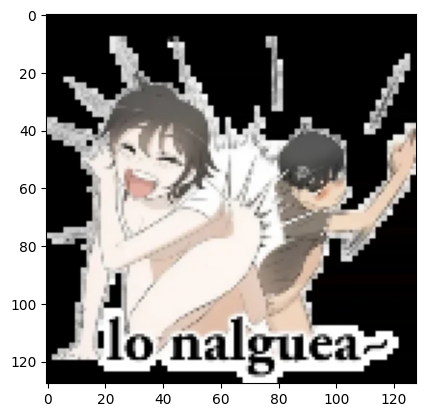

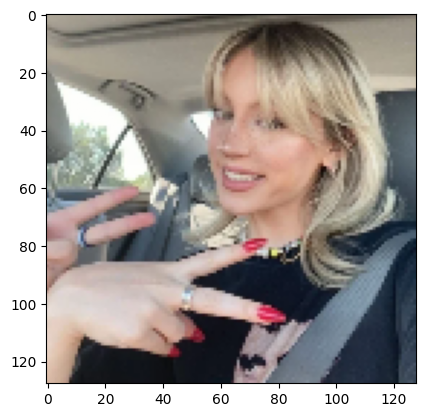

In [38]:
for batch in val_dataloader:
    images, class_nums = batch
    print(images.shape)
    plt.imshow(images[6].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[20].permute(1, 2, 0))
    plt.show()
    plt.show()
    break

In [39]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=False)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [40]:
class AdamModule(L.LightningModule):
    def __init__(self, model, learning_rate, weight):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight = weight
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]
        

    def training_step(self, train_batch, batch_idx):
        self.model.train()
        images, target = train_batch
        loss = self.model(images, target)
        train_accuracy = self.model.get_accuracy(reset=False)
        self.log("train_accuracy", train_accuracy, prog_bar=True, logger=True)
        self.log("train_loss", loss, prog_bar=True, logger=True)

        self.train_losses.append(loss.item())
        self.train_accuracies.append(train_accuracy)
        return loss

    def validation_step(self, val_batch, batch_idx):
        self.model.eval()
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True, logger=True)

        val_accuracy = self.model.get_accuracy(reset=False)
        self.log("val_accuracy", val_accuracy, prog_bar=True, logger=True)

        self.val_losses.append(loss.item())
        self.val_accuracies.append(val_accuracy)
        return loss

    def on_train_epoch_end(self):
        train_accuracy = self.model.get_accuracy(reset=True)
        self.log("train_accuracy_epoch", train_accuracy, prog_bar=True, logger=True)
        self.plot_metrics()

    def on_validation_epoch_end(self):
        val_accuracy = self.model.get_accuracy(reset=True)
        self.log("val_accuracy_epoch", val_accuracy, prog_bar=True, logger=True)
        
    def plot_metrics(self):
        plt.figure(figsize=(20, 5))

        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss During Training")
        plt.legend()

        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.train_accuracies) + 1), self.train_accuracies, label="Train Accuracy")
        plt.plot(range(1, len(self.val_accuracies) + 1), self.val_accuracies, label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy During Training")
        plt.legend()

        
        plt.pause(0.1)
        plt.draw()

Я всячески модифицировал функцию обучения, здесь отображаются все основные графики, также попробовал использовать scheduler. Далее также всезде использую lr_autofinder

В общем, для первой своей модели я решил взять архитектуру похожую на одну из свохи моделей в первой домашке, только там были линейные слои и между ними нормализация а здесь соответственно сверточные слои так как работаем с картинками. Также добавил больше таких слоев в надежде увидеть хорошее качество.

In [41]:
class Model_1(nn.Module):
    def __init__(self, num_classes=100):
        super(Model_1, self).__init__()

       
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)

        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
    def _forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.pool(x)

        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        x = self.pool(x)

        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.bn6(self.conv6(x))
        x = F.relu(x)
        x = self.pool(x)

        
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.bn8(self.conv8(x))
        x = F.relu(x)
        x = self.pool(x)

        
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def forward(self, images, target=None):
        
        output = self._forward(images)

        
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [ ]:
seed_everything(52)
model_1 = Model_1().to(device)
module_1 = AdamModule(model_1, learning_rate = 0.005, weight = 0.0001)

trainer = L.Trainer(max_epochs=4)
tuner = Tuner(trainer)
lr_find_results = tuner.lr_find(
    module_1, 
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    min_lr=0.001, 
    max_lr=1.0, 
    early_stop_threshold=None
)
fig = lr_find_results.plot()
fig.show()
trainer.fit(module_1, train_dataloader, val_dataloader)

Как можно заметить модель сильно переобучается, добавлю еще дропауты для того чтобы уменьшить переобучение.

In [ ]:
class Model_1_improved(nn.Module):
    def __init__(self, num_classes=100):
        super(Model_1_improved, self).__init__()

        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25) 

        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.25)  

        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout2d(0.25)  

        
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout2d(0.25)  

        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)  

        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)  

       
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)  

       
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool(x)
        x = self.dropout4(x)  

        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

            return loss
        else:
            return output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [ ]:
seed_everything(52)
model_1_1 = Model_1_improved().to(device)
module_1_1 = AdamModule(model_1_1, learning_rate = 0.005, weight = 0.0001)

trainer = L.Trainer(max_epochs=5)
tuner = Tuner(trainer)
lr_find_results = tuner.lr_find(
    module_1_1, 
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    min_lr=0.001, 
    max_lr=1.0, 
    early_stop_threshold=None
)
fig = lr_find_results.plot()
fig.show()
trainer.fit(module_1_1, train_dataloader, val_dataloader)

Далее попробую поэксперментировать с моделями. Теперь попробую поиграться с параметрами сверточного слоя, поменяю размрность ядра и добавлю паддинг.

In [ ]:
class Model_2(torch.nn.Module):
    def __init__(self, num_classes=100):
        super(Model_2, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=128 * 16 * 16, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=num_classes),
        )
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, images, target=None):

        output = self._forward(images)


        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [ ]:
seed_everything(52)
model_2 = Model_2().to(device)
module_2 = AdamModule(model_2, learning_rate = 0.005, weight = 0.0001)

trainer = L.Trainer(max_epochs=5)
tuner = Tuner(trainer)
lr_find_results = tuner.lr_find(
    module_2, 
    train_dataloaders=train_dataloader, 
    val_dataloaders= val_dataloader, 
    min_lr=0.001, 
    max_lr=1.0, 
    early_stop_threshold=None
)
fig = lr_find_results.plot()
fig.show()
trainer.fit(module_2, train_dataloader, val_dataloader)

Модель также сильно переобучивается. За основу следующей модели я решил взять семинарскую и немного изменить ее.

In [ ]:
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),  
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 100)
        )
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
        
    def _forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    def forward(self, images, target=None):

        output = self._forward(images)


        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [ ]:

seed_everything(100)
model_3 = Model_3().to(device)
module_3 = AdamModule(model_3, learning_rate = 0.001, weight = 0.0001)
trainer = L.Trainer(max_epochs=14)
tuner = Tuner(trainer)
lr_find_results = tuner.lr_find(
    module_3, 
    train_dataloaders= train_dataloader,
    val_dataloaders= val_dataloader,
    min_lr=0.001, 
    max_lr=1.0, 
    early_stop_threshold=None
)
fig = lr_find_results.plot()
fig.show()
trainer.fit(module_3, train_dataloader, val_dataloader)

Качество модели также достаточно низкое. Вернусь ко второй модели и немного изменю ее, добавлю побольше слоев в нее. Плюс изменю количество эпох

In [ ]:
class Model_2_improved(nn.Module):
    def __init__(self, num_classes=100):
        super(Model_2_improved, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )

     
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=128 * 16 * 16, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=num_classes),
        )
        
        self.loss_func = nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, images, target=None):
        output = self._forward(images)
        
        if target is not None:
            loss = self.loss_func(output, target)
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)
            return loss

        return output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [ ]:

seed_everything(100)
model_4 = Model_2_improved().to(device)
module_4 = AdamModule(model_4, learning_rate = 0.001, weight = 0.0001)
trainer = L.Trainer(max_epochs=10)
tuner = Tuner(trainer)
lr_find_results = tuner.lr_find(
    module_4, 
    train_dataloaders= train_dataloader,
    val_dataloaders= val_dataloader,
    min_lr=0.001, 
    max_lr=1.0, 
    early_stop_threshold=None
)
fig = lr_find_results.plot()
fig.show()
trainer.fit(module_4, train_dataloader, val_dataloader)



Дальше я хочу доработать третью модель. Добавлю больше слоев. Поменяю параметры внутри модели. Также поставлю сильно больше эпох для обучения.

In [42]:
class Model_3_improved(nn.Module):
    def __init__(self):
        super(Model_3_improved, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 100)
        )

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
        
    def _forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)
            self.update_accuracy(output, target)
            return loss

        return output

    def update_accuracy(self, output, target):
        
        self.targets = torch.cat((self.targets, target.cpu()), 0)
        pred = torch.argmax(output, dim=-1)
        self.preds = torch.cat((self.preds, pred.cpu()), 0)
        
        
        self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=100)

    def get_accuracy(self, reset=False):
        current_accuracy = self.accuracy

        if reset:
            
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()

        return current_accuracy

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]

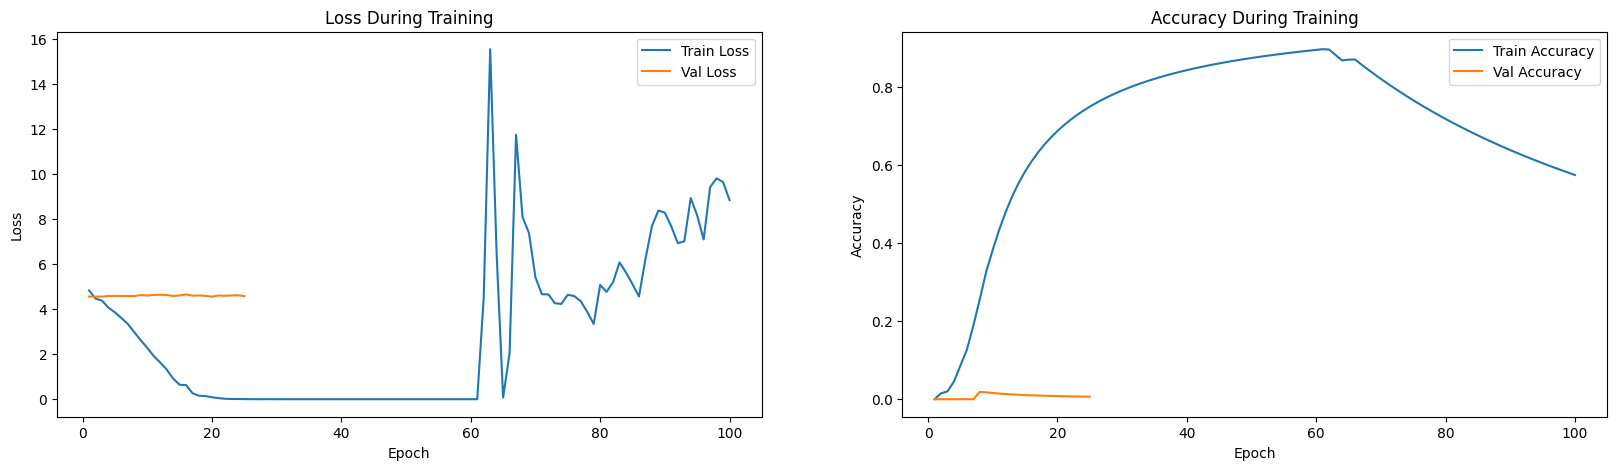

`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]
Learning rate set to 0.002630267991895382
Restoring states from the checkpoint path at c:\Users\banym\Downloads\.lr_find_71628d55-2cac-413c-a41b-297e42051633.ckpt
Restored all states from the checkpoint at c:\Users\banym\Downloads\.lr_find_71628d55-2cac-413c-a41b-297e42051633.ckpt
C:\Users\banym\AppData\Local\Temp\ipykernel_9040\164243735.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Model_3_improved | 3.4 M  | train
---------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.748    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 457/457 [00:26<00:00, 17.44it/s, v_num=151, train_accuracy=0.127, train_loss=6.290, val_loss=4.510, val_accuracy=0.130, val_accuracy_epoch=0.127]

<Figure size 640x480 with 0 Axes>

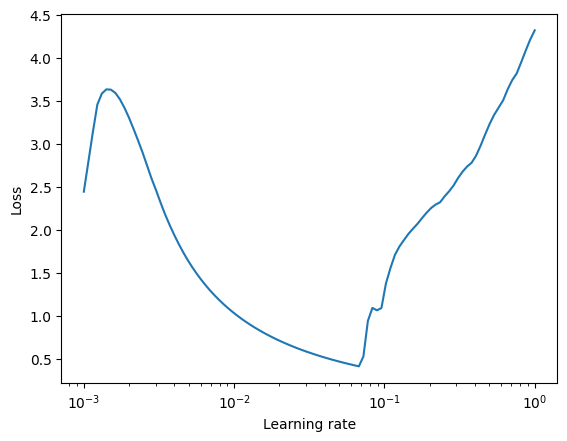

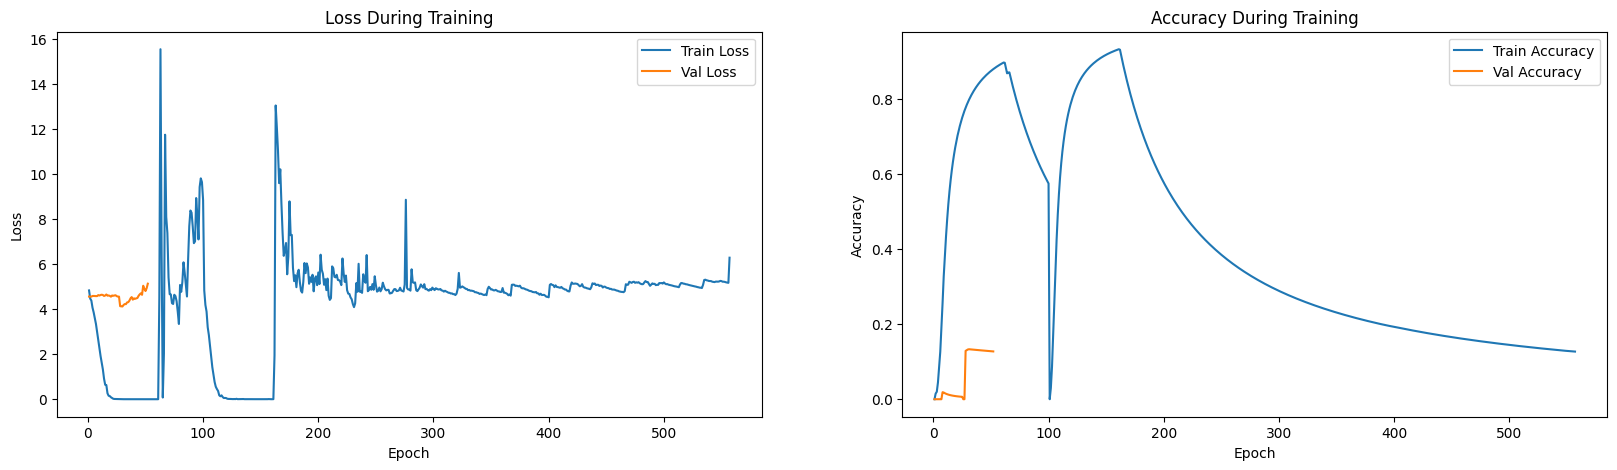

Epoch 1: 100%|██████████| 457/457 [00:25<00:00, 17.65it/s, v_num=151, train_accuracy=0.139, train_loss=5.010, val_loss=4.130, val_accuracy=0.142, val_accuracy_epoch=0.139, train_accuracy_epoch=0.127]

<Figure size 640x480 with 0 Axes>

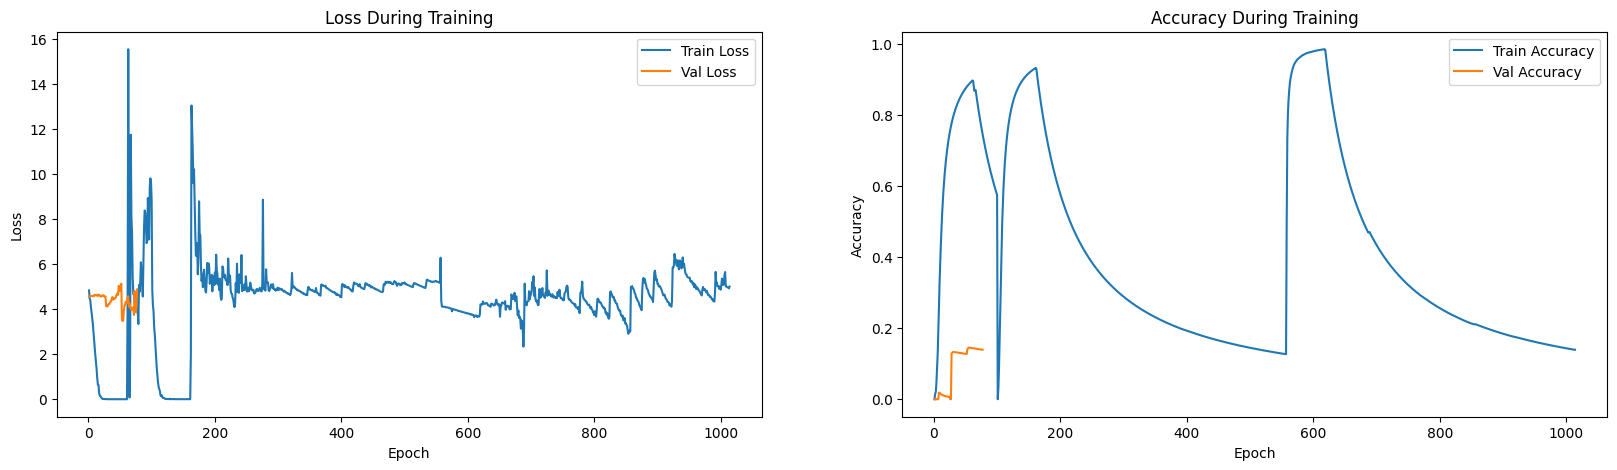

Epoch 2: 100%|██████████| 457/457 [00:26<00:00, 17.21it/s, v_num=151, train_accuracy=0.174, train_loss=5.140, val_loss=3.890, val_accuracy=0.176, val_accuracy_epoch=0.172, train_accuracy_epoch=0.139]

<Figure size 640x480 with 0 Axes>

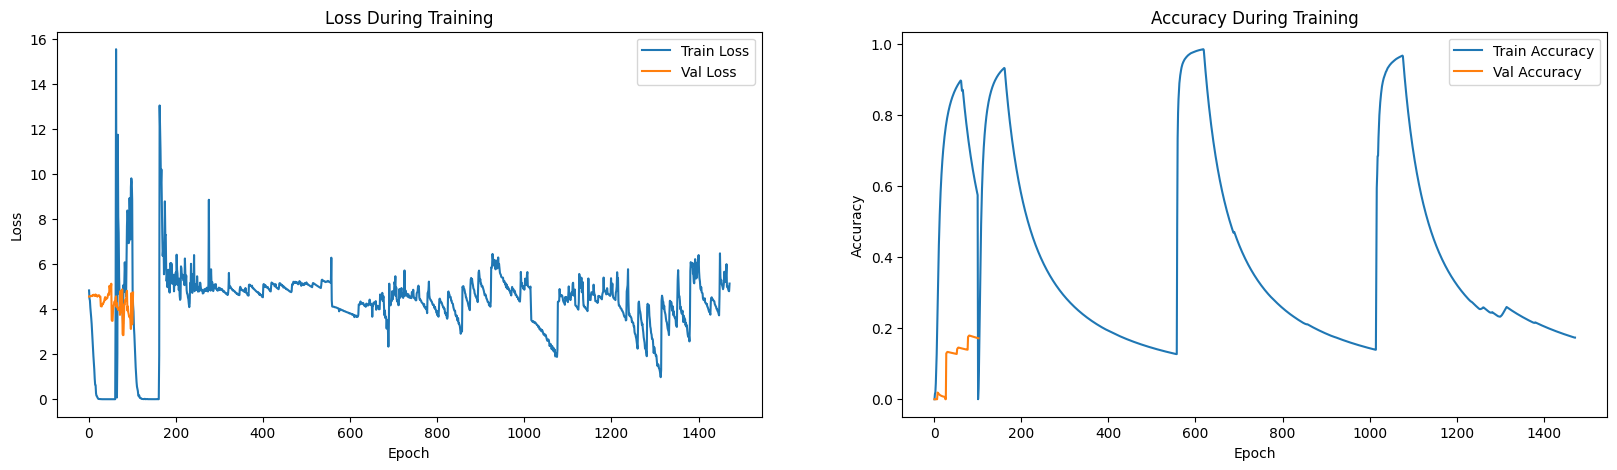

Epoch 3: 100%|██████████| 457/457 [00:29<00:00, 15.28it/s, v_num=151, train_accuracy=0.161, train_loss=6.090, val_loss=3.810, val_accuracy=0.162, val_accuracy_epoch=0.159, train_accuracy_epoch=0.172]

<Figure size 640x480 with 0 Axes>

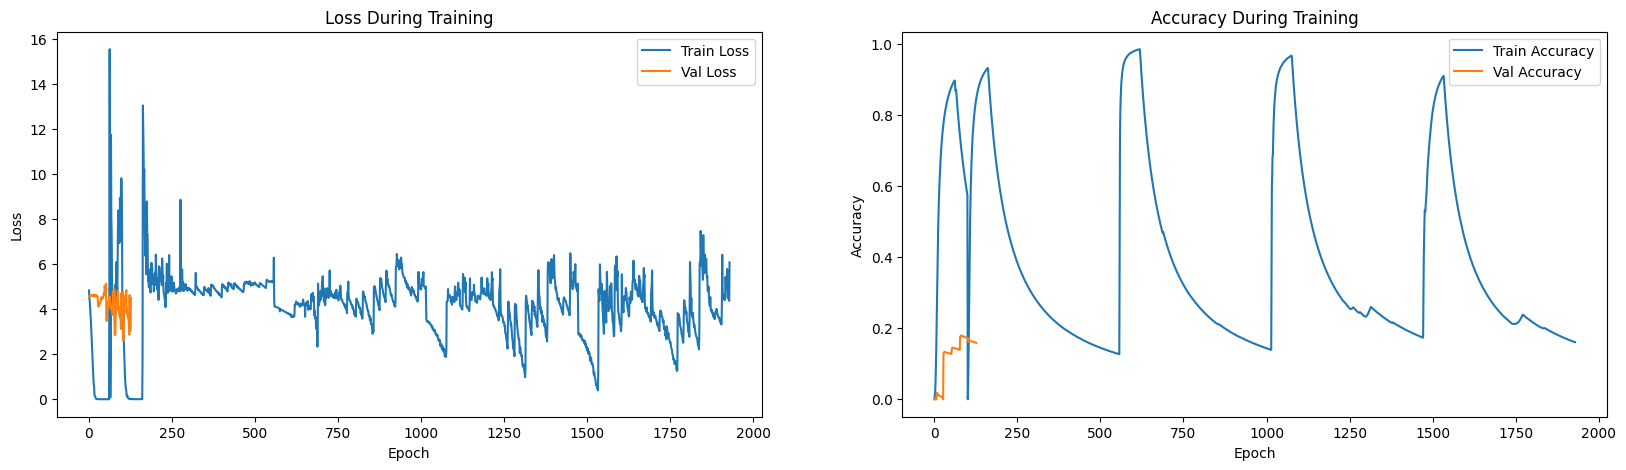

Epoch 4: 100%|██████████| 457/457 [00:29<00:00, 15.36it/s, v_num=151, train_accuracy=0.144, train_loss=4.380, val_loss=3.790, val_accuracy=0.140, val_accuracy_epoch=0.139, train_accuracy_epoch=0.159]

<Figure size 640x480 with 0 Axes>

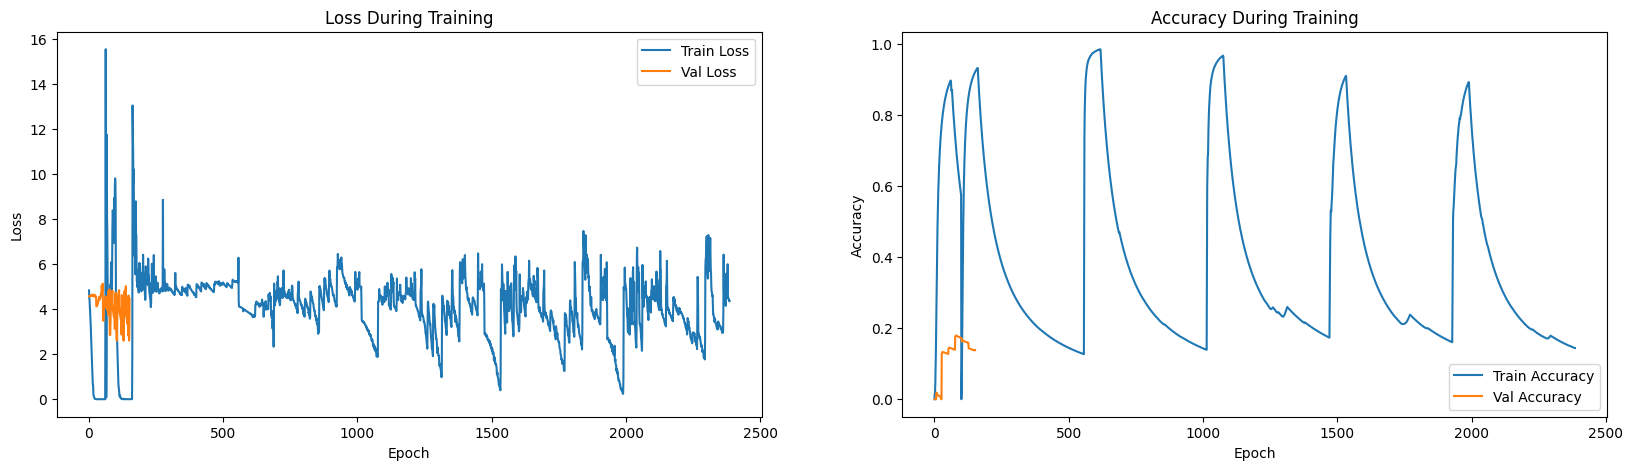

Epoch 5: 100%|██████████| 457/457 [00:28<00:00, 15.93it/s, v_num=151, train_accuracy=0.115, train_loss=4.320, val_loss=3.740, val_accuracy=0.119, val_accuracy_epoch=0.116, train_accuracy_epoch=0.139]

<Figure size 640x480 with 0 Axes>

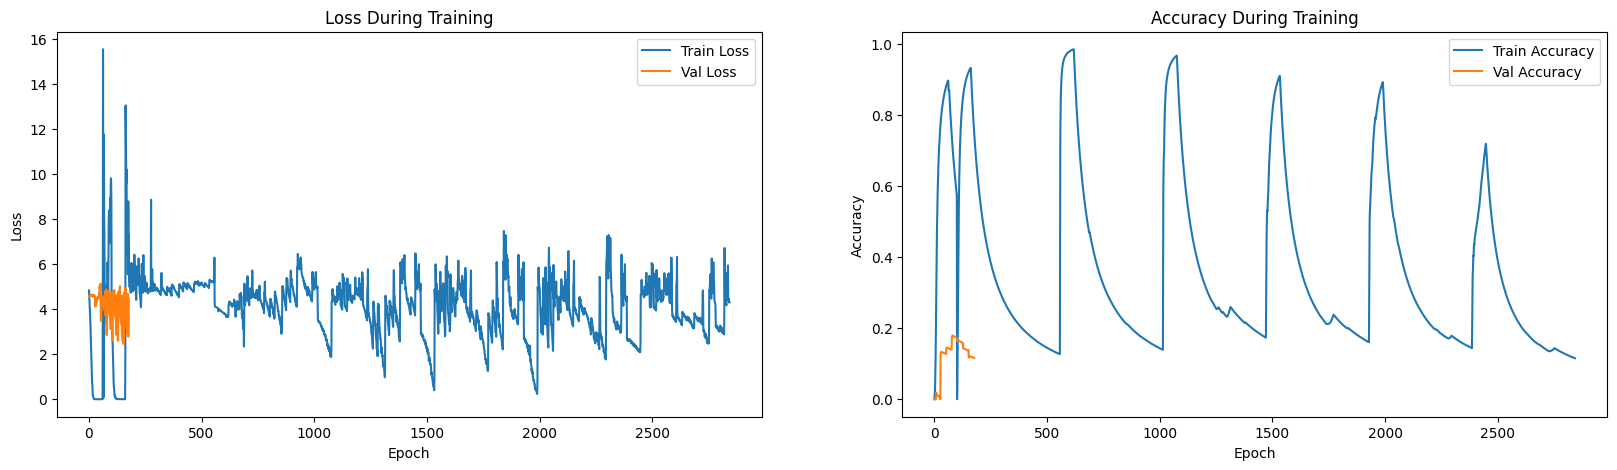

Epoch 6: 100%|██████████| 457/457 [00:27<00:00, 16.52it/s, v_num=151, train_accuracy=0.133, train_loss=4.520, val_loss=3.730, val_accuracy=0.137, val_accuracy_epoch=0.134, train_accuracy_epoch=0.116]

<Figure size 640x480 with 0 Axes>

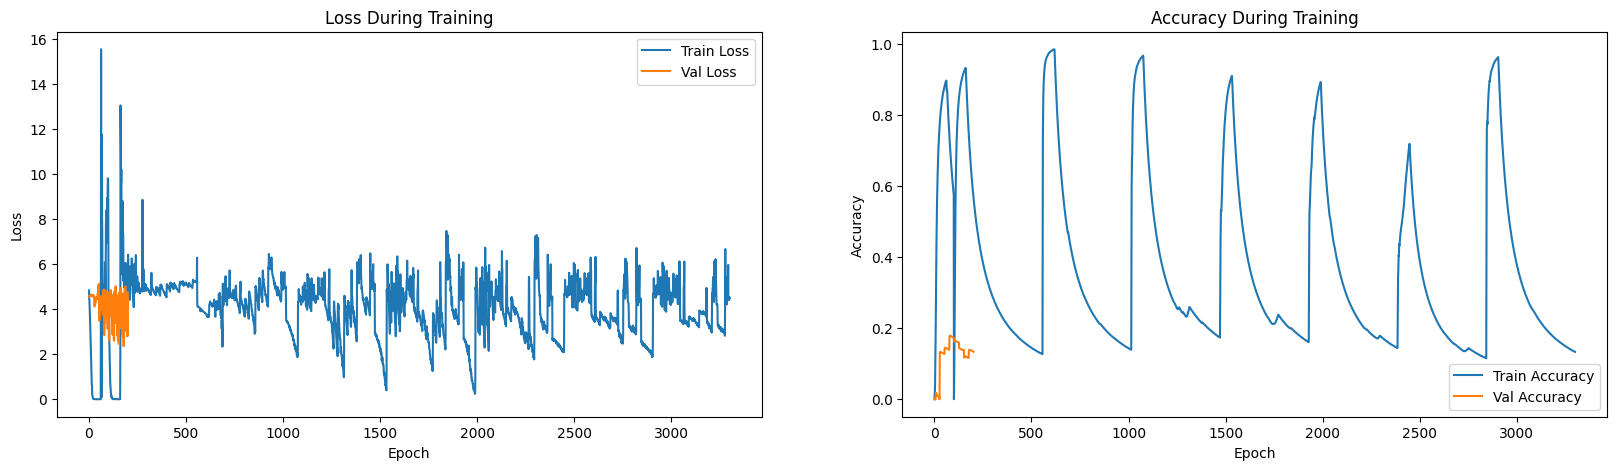

Epoch 7: 100%|██████████| 457/457 [00:26<00:00, 17.38it/s, v_num=151, train_accuracy=0.139, train_loss=4.140, val_loss=3.710, val_accuracy=0.142, val_accuracy_epoch=0.139, train_accuracy_epoch=0.134]

<Figure size 640x480 with 0 Axes>

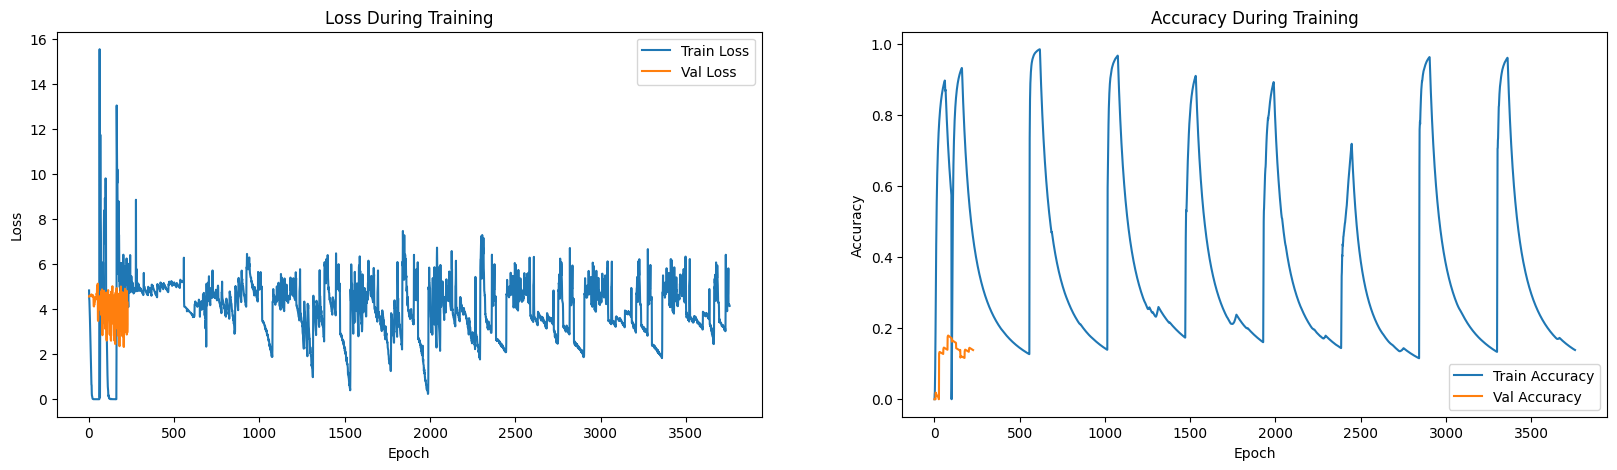

Epoch 8: 100%|██████████| 457/457 [00:27<00:00, 16.34it/s, v_num=151, train_accuracy=0.133, train_loss=4.260, val_loss=3.710, val_accuracy=0.136, val_accuracy_epoch=0.133, train_accuracy_epoch=0.139]

<Figure size 640x480 with 0 Axes>

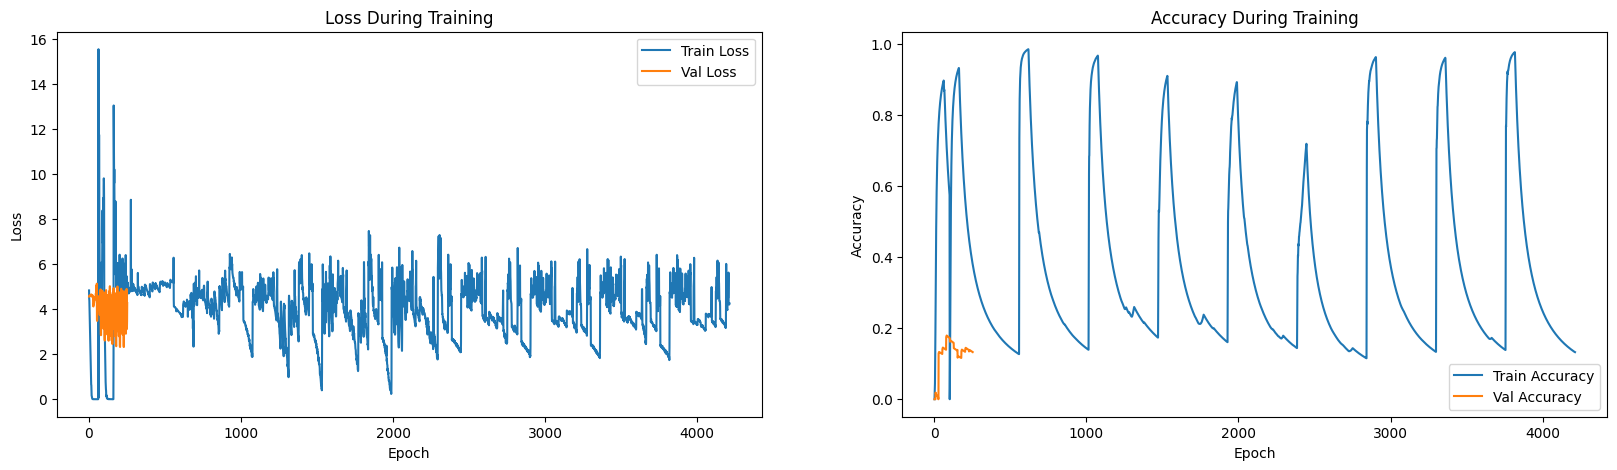

Epoch 9: 100%|██████████| 457/457 [00:27<00:00, 16.72it/s, v_num=151, train_accuracy=0.135, train_loss=4.100, val_loss=3.700, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.133]

<Figure size 640x480 with 0 Axes>

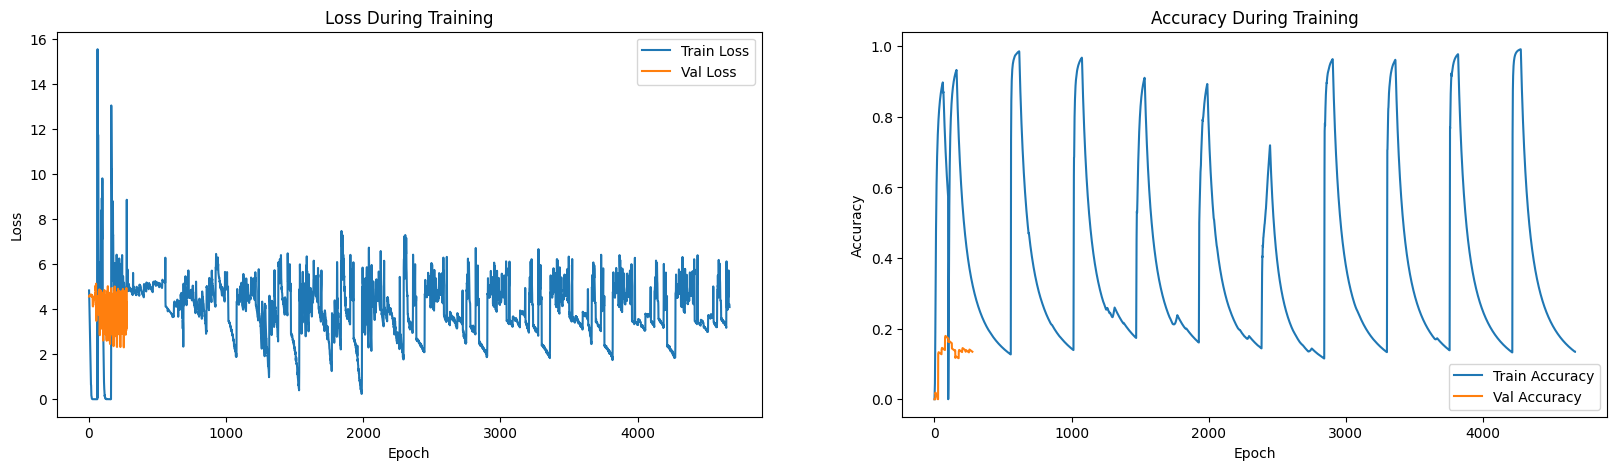

Epoch 10: 100%|██████████| 457/457 [00:25<00:00, 17.59it/s, v_num=151, train_accuracy=0.135, train_loss=4.240, val_loss=3.690, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

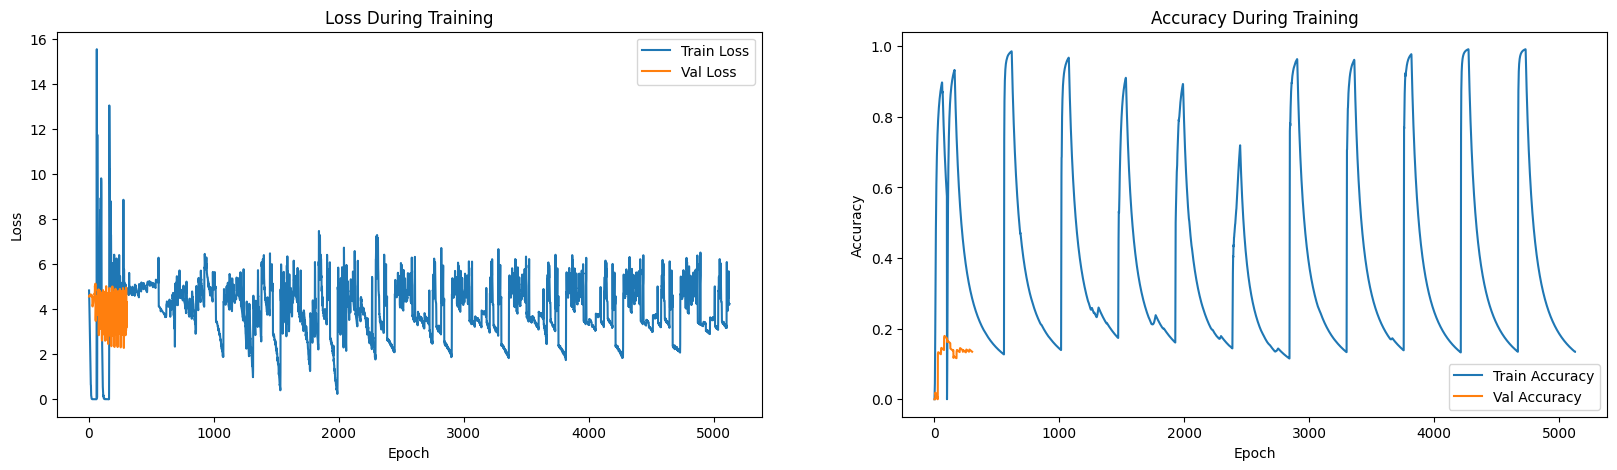

Epoch 11: 100%|██████████| 457/457 [00:26<00:00, 17.49it/s, v_num=151, train_accuracy=0.134, train_loss=4.090, val_loss=3.690, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

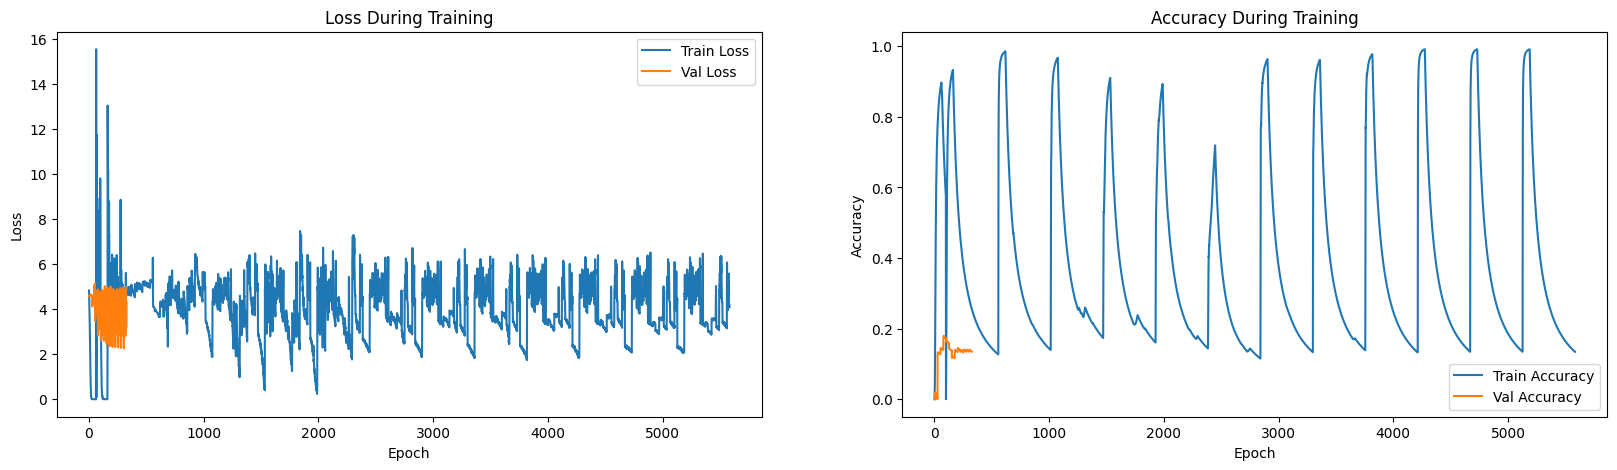

Epoch 12: 100%|██████████| 457/457 [00:26<00:00, 17.47it/s, v_num=151, train_accuracy=0.135, train_loss=4.130, val_loss=3.690, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

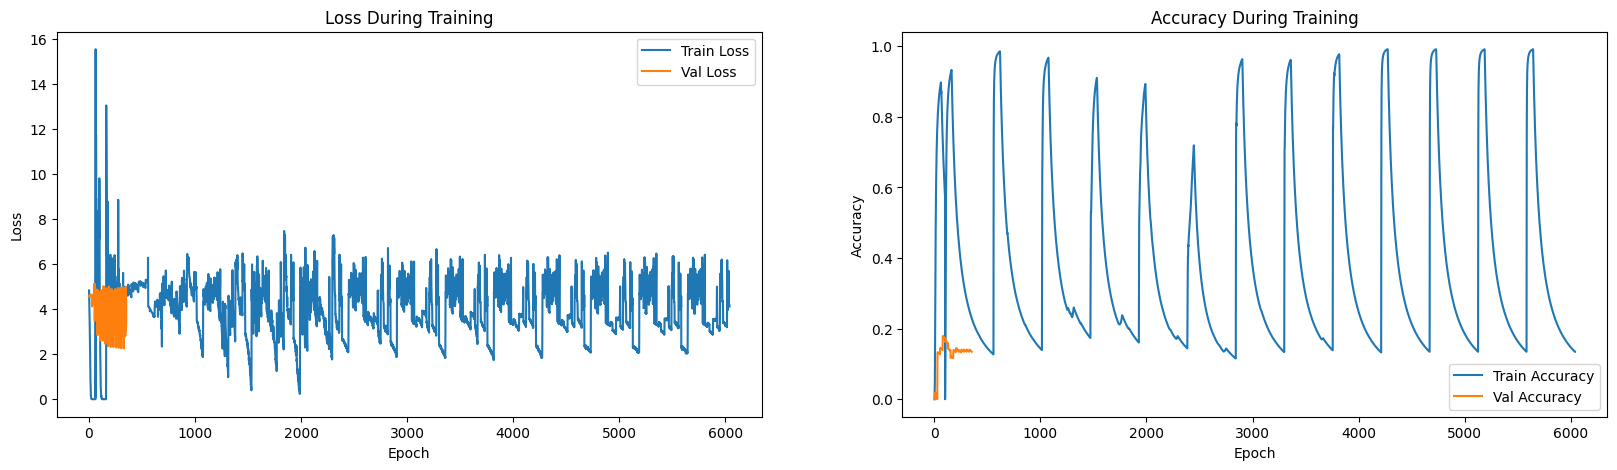

Epoch 13: 100%|██████████| 457/457 [00:26<00:00, 17.55it/s, v_num=151, train_accuracy=0.135, train_loss=4.300, val_loss=3.690, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

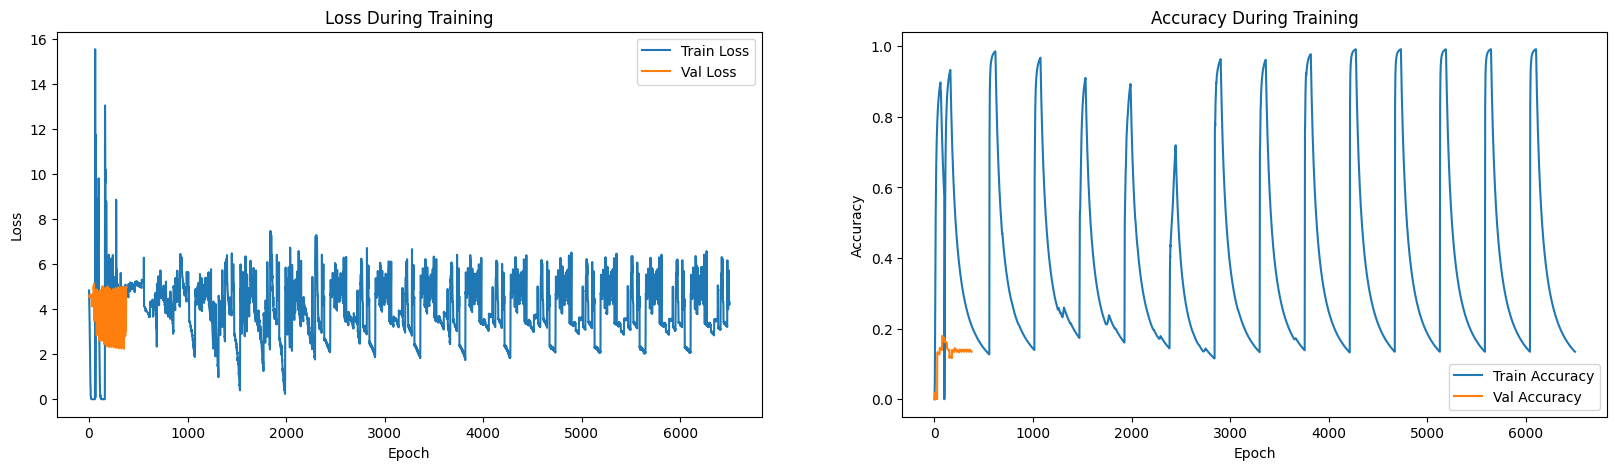

Epoch 14: 100%|██████████| 457/457 [00:26<00:00, 17.52it/s, v_num=151, train_accuracy=0.135, train_loss=4.150, val_loss=3.680, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

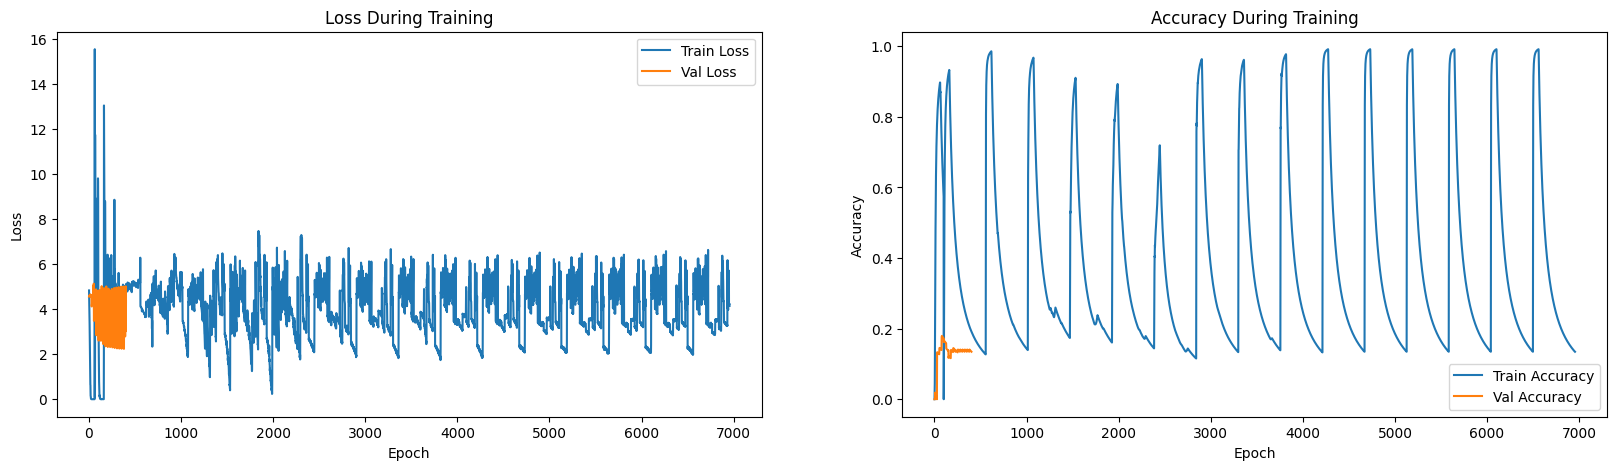

Epoch 15: 100%|██████████| 457/457 [00:26<00:00, 17.53it/s, v_num=151, train_accuracy=0.135, train_loss=4.170, val_loss=3.680, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

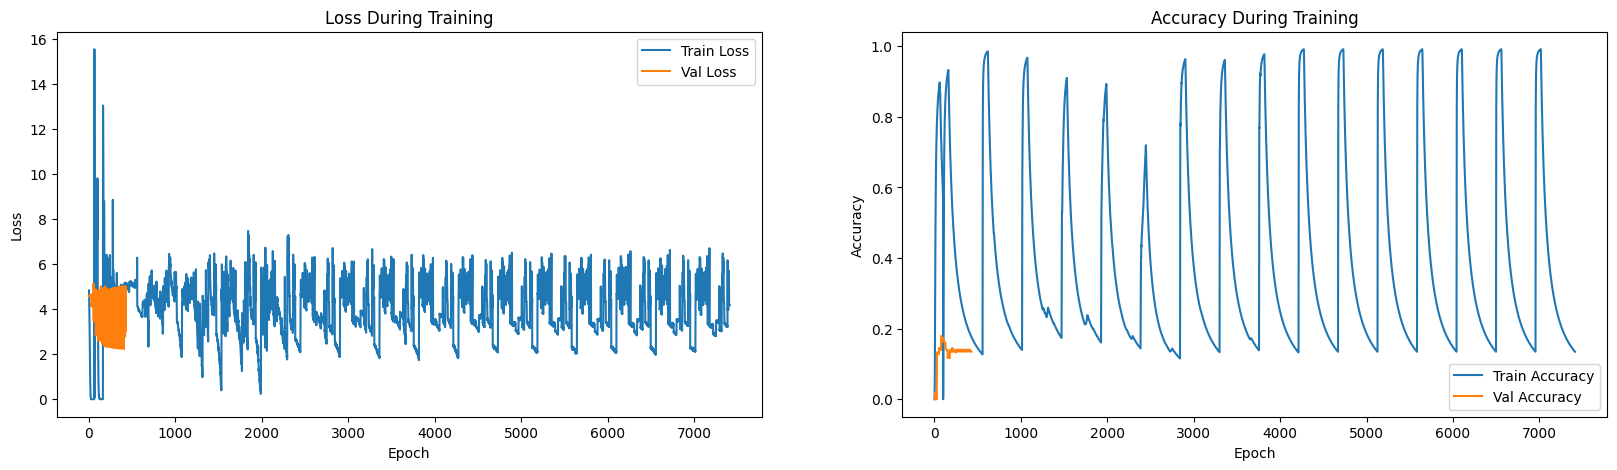

Epoch 16: 100%|██████████| 457/457 [00:25<00:00, 17.58it/s, v_num=151, train_accuracy=0.135, train_loss=4.200, val_loss=3.680, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

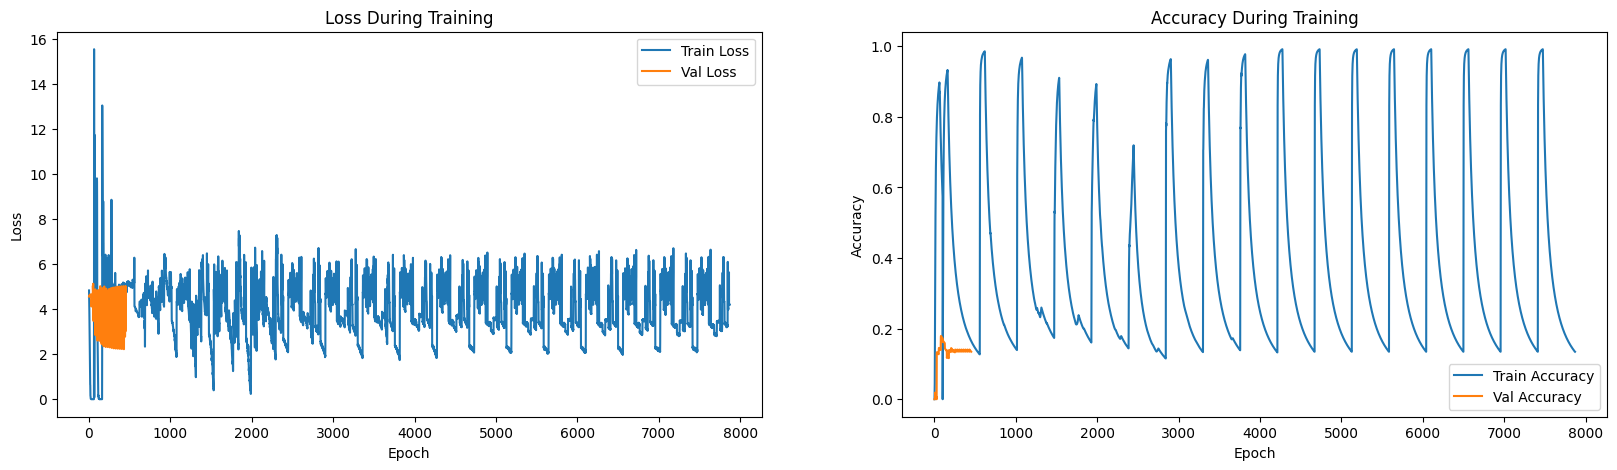

Epoch 17: 100%|██████████| 457/457 [00:25<00:00, 17.58it/s, v_num=151, train_accuracy=0.135, train_loss=4.150, val_loss=3.680, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

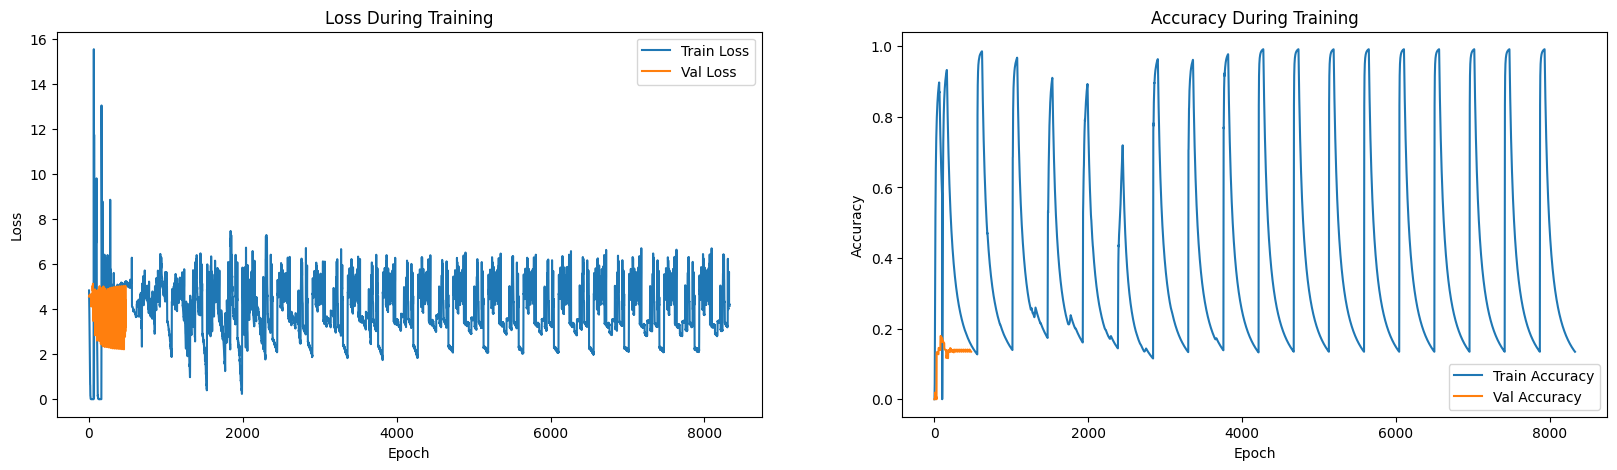

Epoch 18: 100%|██████████| 457/457 [00:26<00:00, 17.53it/s, v_num=151, train_accuracy=0.135, train_loss=4.100, val_loss=3.680, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

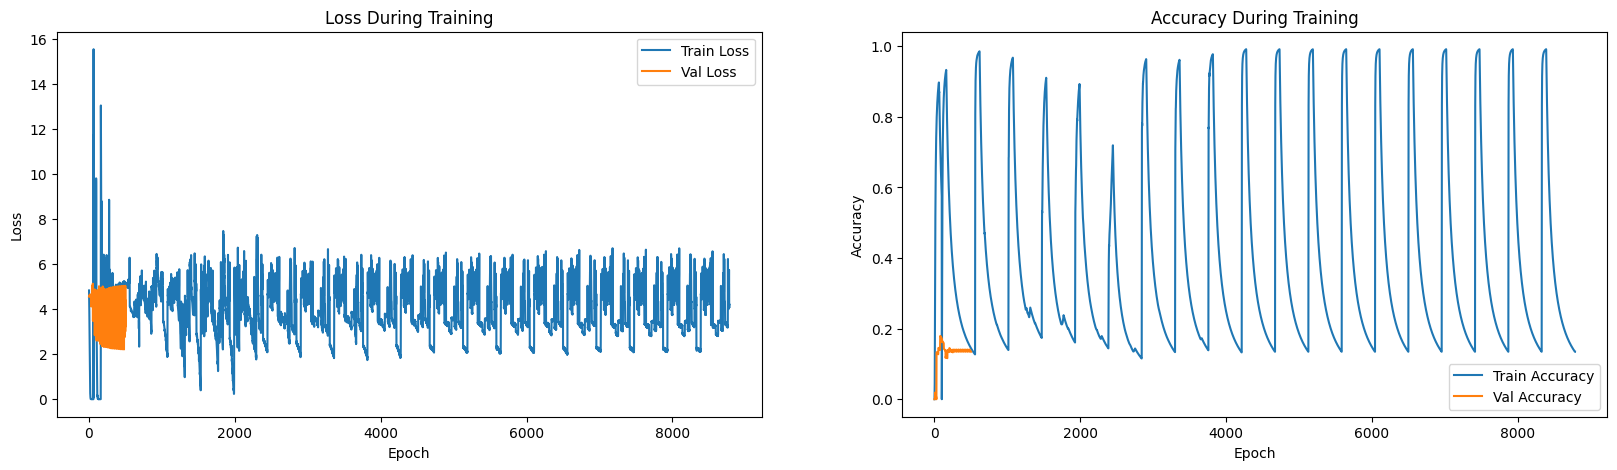

Epoch 19: 100%|██████████| 457/457 [00:26<00:00, 17.50it/s, v_num=151, train_accuracy=0.135, train_loss=4.210, val_loss=3.680, val_accuracy=0.138, val_accuracy_epoch=0.135, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

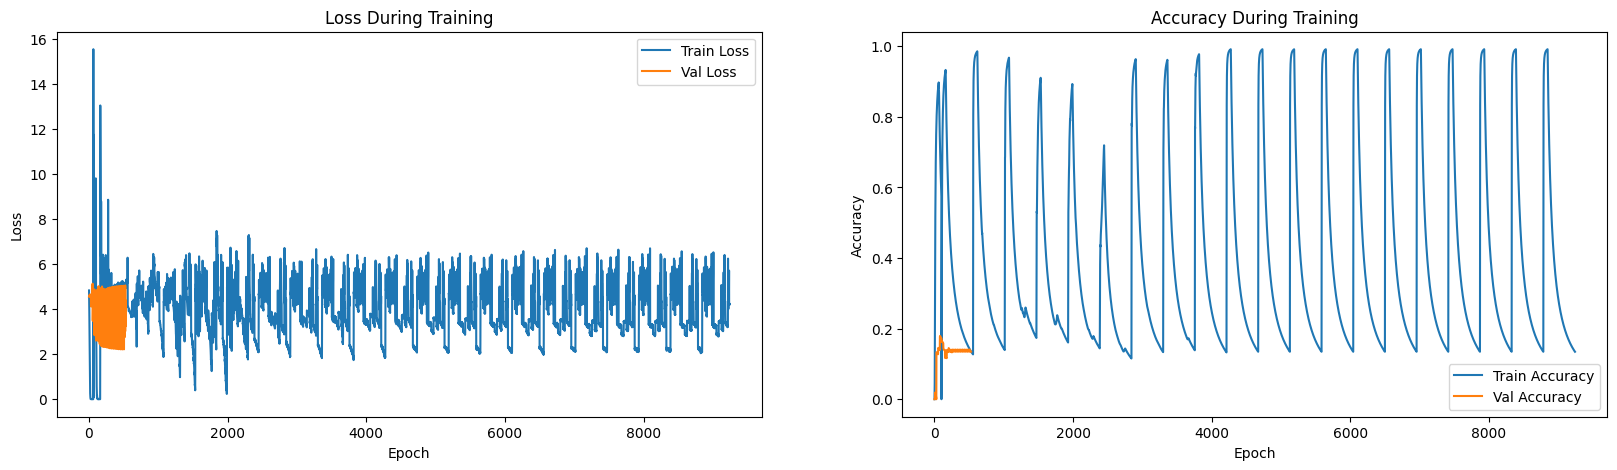

Epoch 20: 100%|██████████| 457/457 [00:28<00:00, 16.32it/s, v_num=151, train_accuracy=0.134, train_loss=4.140, val_loss=3.680, val_accuracy=0.137, val_accuracy_epoch=0.134, train_accuracy_epoch=0.135]

<Figure size 640x480 with 0 Axes>

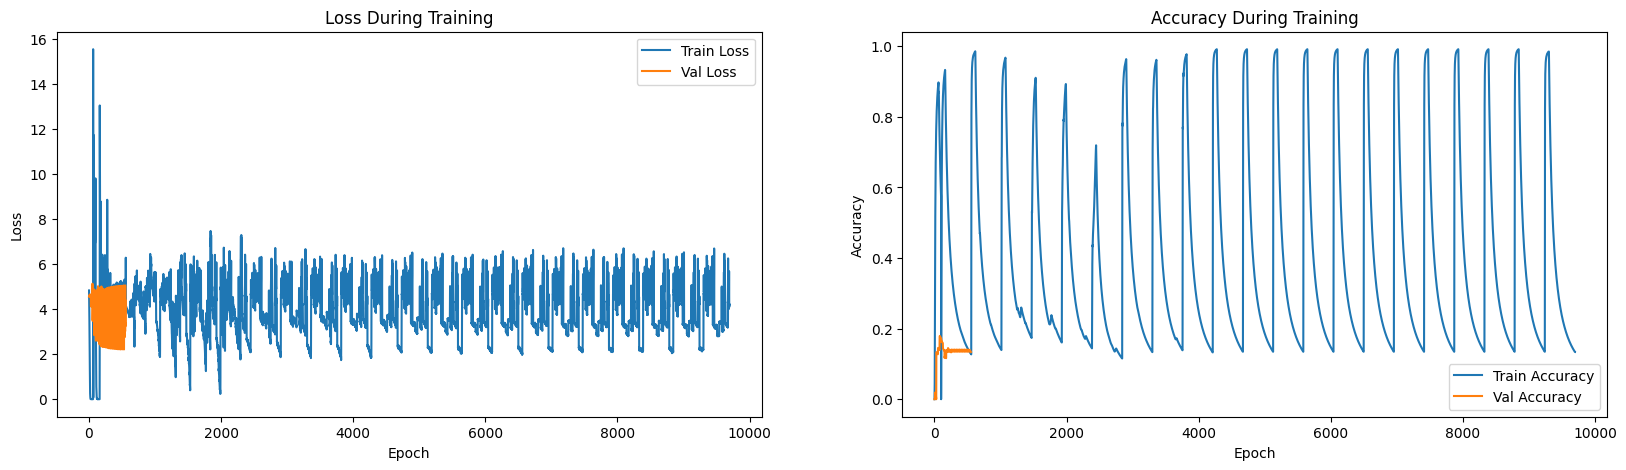

Epoch 21: 100%|██████████| 457/457 [00:26<00:00, 17.50it/s, v_num=151, train_accuracy=0.134, train_loss=4.190, val_loss=3.680, val_accuracy=0.137, val_accuracy_epoch=0.134, train_accuracy_epoch=0.134]

<Figure size 640x480 with 0 Axes>

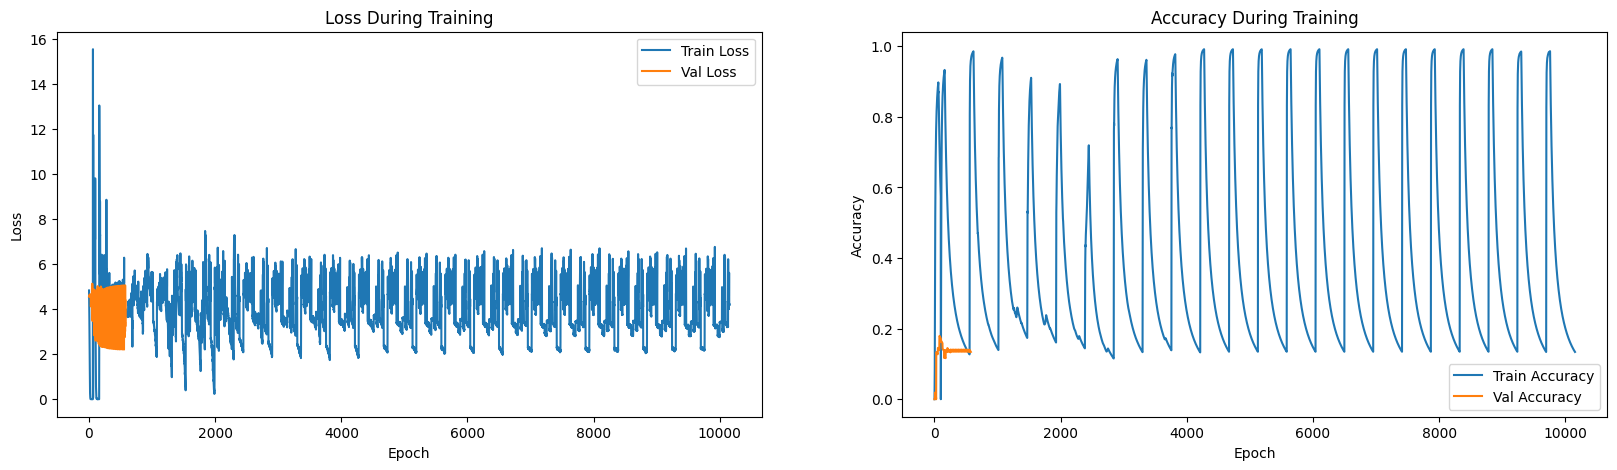

Epoch 22: 100%|██████████| 457/457 [00:26<00:00, 17.48it/s, v_num=151, train_accuracy=0.134, train_loss=4.240, val_loss=3.680, val_accuracy=0.137, val_accuracy_epoch=0.134, train_accuracy_epoch=0.134]

<Figure size 640x480 with 0 Axes>

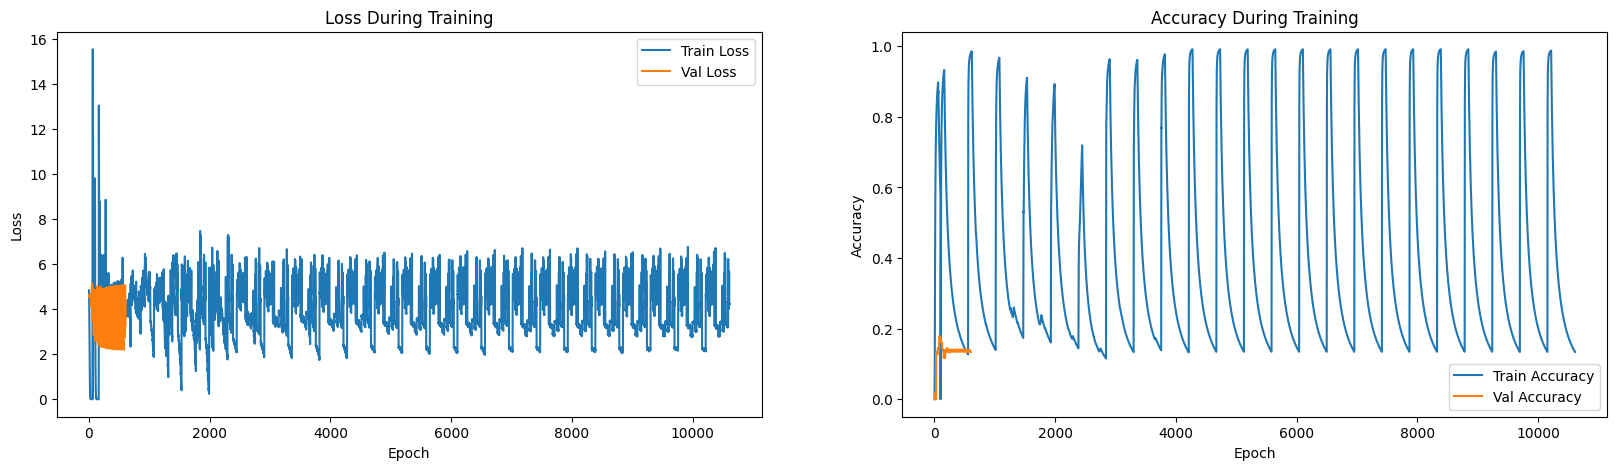

Epoch 23: 100%|██████████| 457/457 [00:26<00:00, 17.56it/s, v_num=151, train_accuracy=0.140, train_loss=4.190, val_loss=3.680, val_accuracy=0.143, val_accuracy_epoch=0.140, train_accuracy_epoch=0.134]

<Figure size 640x480 with 0 Axes>

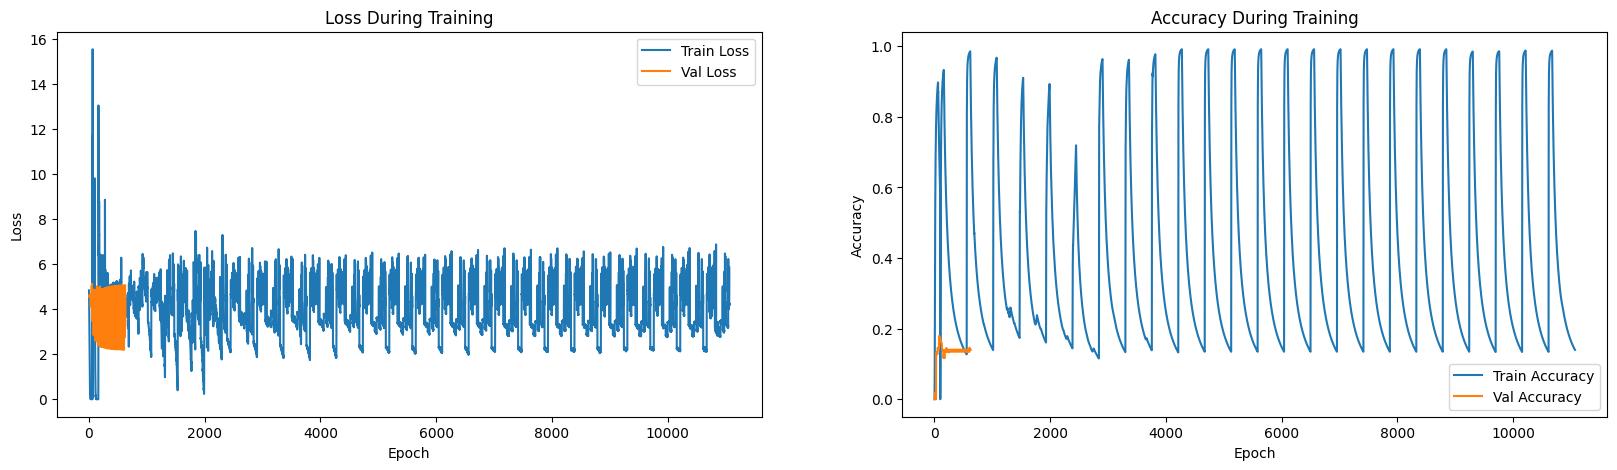

Epoch 24: 100%|██████████| 457/457 [00:26<00:00, 17.53it/s, v_num=151, train_accuracy=0.147, train_loss=4.230, val_loss=3.680, val_accuracy=0.150, val_accuracy_epoch=0.146, train_accuracy_epoch=0.140]

<Figure size 640x480 with 0 Axes>

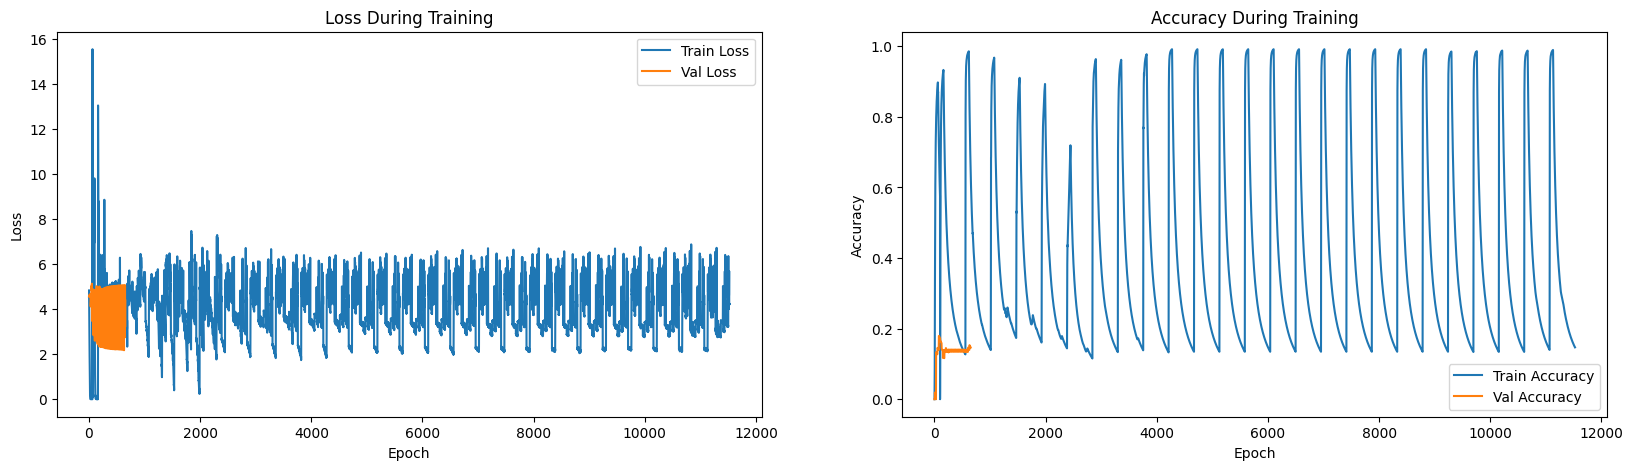

Epoch 25: 100%|██████████| 457/457 [00:26<00:00, 17.23it/s, v_num=151, train_accuracy=0.150, train_loss=4.170, val_loss=3.680, val_accuracy=0.153, val_accuracy_epoch=0.149, train_accuracy_epoch=0.146]

<Figure size 640x480 with 0 Axes>

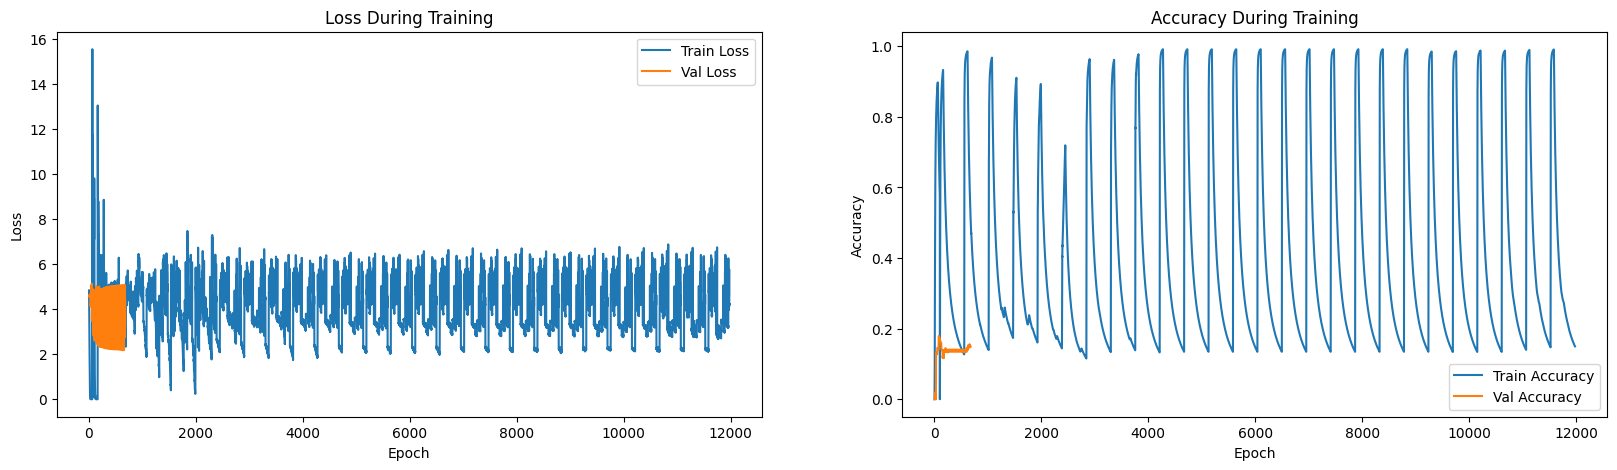

`Trainer.fit` stopped: `max_epochs=26` reached.


Epoch 25: 100%|██████████| 457/457 [00:27<00:00, 16.69it/s, v_num=151, train_accuracy=0.150, train_loss=4.170, val_loss=3.680, val_accuracy=0.153, val_accuracy_epoch=0.149, train_accuracy_epoch=0.146]


<Figure size 640x480 with 0 Axes>

In [56]:
seed_everything(52)
model_6 = Model_3_improved().to(device)
module_6 = AdamModule(model_6, learning_rate = 0.005, weight = 0.00001)

trainer = L.Trainer(max_epochs=26)
tuner = Tuner(trainer)
lr_find_results = tuner.lr_find(
    module_6, 
    train_dataloaders=train_dataloader, 
    val_dataloaders= val_dataloader,
    min_lr=0.001, 
    max_lr=1.0, 
    early_stop_threshold=None
)
fig = lr_find_results.plot()
fig.show()
trainer.fit(module_6, train_dataloader, val_dataloader)

Модель выдала очень хорошее качество! Его можно испльзовать и для второго задания.

In [57]:
accuracy_model = evaluate_task(model_6, val_dataloader)
print(accuracy_model)
print(f"Оценка за это задание составит {np.clip(5 * accuracy_model / 0.24, 0, 5):.2f} баллов")

100%|██████████| 25/25 [00:11<00:00,  2.21it/s]

tensor(0.3882)
Оценка за это задание составит 5.00 баллов


В рамках задания я рассмотрел множество разных архитектур и подходов. Свой основной обучающий класс я сильно изменил. Все мое обучение базировалось на Adam (Я также использовал в других ноутбуках SGD c моментумом, но так модели обученный с ним показывали качество еще хуже и обучались достаточно долго, я решил их не вставлять в этот итоговый ноутбук.) Также я добавил scheduler, разницы большой я честно говоря не увидел. Сильно экпериментировал с архитектурами, модели с большим количеством слоев и без регуляризации очень сильно переобучаются = не круто. Добавил lr_autofinder, вот он как будто сильно смог уменьшить фронт работы по подбору гиперпараметра. Также добавил weight_decay в Adam, чтобы также избежать проблемы переобучения. 
Также пытался работать с обученными моделями, но они почему-то выдают очень плохое качество и долго обучаются (в этом ноутбуке я опять же не стал добавлять все свои пробные попытки, чтобы совсем не захламлять работу, после этого отчета я добавлю одну из своих наработок, я честно не понимаю почему там такое плохое качество, вроде как сделал все по семинарским тетрадкам)

P.S. очень много времени потратил на то чтобы понять, почему модели не обучались на gpu, а оказывается у меня не та версия торча стояла...

In [88]:
train_transform_2 = transforms.Compose([
    transforms.Resize(128),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.ToTensor(),
])

val_transform_2 = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    
])

In [89]:
train_dataset2 = ImageFolder(train_path, transform=train_transform_2)
val_dataset2 = ImageFolder(val_path, transform=val_transform_2)


train_dataloader2 = DataLoader(train_dataset2, batch_size = 10, num_workers=4, pin_memory=True, persistent_workers=True)
val_dataloader2 = DataLoader(val_dataset2, batch_size = 10, num_workers=4, pin_memory=True, persistent_workers=True)

torch.Size([10, 3, 128, 128])


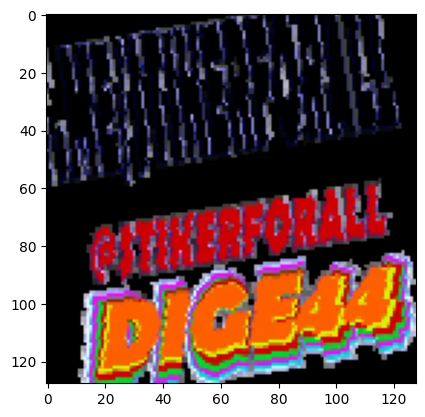

IndexError: index 20 is out of bounds for dimension 0 with size 10

In [ ]:
for batch in train_dataloader2:
    images, class_nums = batch
    print(images.shape)
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[10].permute(1, 2, 0))
    plt.show()
    plt.show()
    break

In [92]:
from torchvision.models import densenet169
from torchmetrics.functional import accuracy

class DenseNet169(L.LightningModule):
    def __init__(self, pretrained: bool = False, num_classes: int = 100) -> None:
        super().__init__()
        self.pretrained = pretrained
        self.num_classes = num_classes

        if pretrained:
          
            self.model = densenet169(pretrained=True)
          
            for param in self.model.parameters():
                param.requires_grad = False
            
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, num_classes)
            
            self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr = 0.005)
        else:
           
            self.model = densenet169(pretrained=False)
            
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, num_classes)
            
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.005)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, targets = train_batch
        preds = self.forward(images)
        loss = self.loss_fn(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, targets = val_batch
        preds = self.forward(images)
        loss = self.loss_fn(preds, targets)
        acc = accuracy(
            torch.argmax(preds, dim=-1).long(),
            targets.long(),
            task='multiclass',
            num_classes=self.num_classes
        )
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
model50 = DenseNet169(pretrained=True)
trainer = L.Trainer(max_epochs=21)
trainer.fit(model50, train_dataloader2, val_dataloader2)

В общем модель плохо обучается и долго. 